### **Multi-label Email Classification Fine-Tuning Task on BERT Variants**

**Objective:** The goal of this task is to address the challenge of disorganized email inboxes, where multiple categories of emails are mixed together. Users often have to go through each email individually, making it difficult to quickly identify their type or priority. By fine-tuning BERT variants for multi-label classification, we aim to automatically categorize emails into their respective classes, improving inbox organization and user efficiency.

**Implementation Steps:**

#### **Project Setup**

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import chain

from datasets import load_dataset
import torch 
from torch.utils.data import random_split
import gc
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from peft import LoraConfig, get_peft_model, TaskType

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import (
    precision_recall_fscore_support, 
    hamming_loss, 
    jaccard_score,
    classification_report,
    multilabel_confusion_matrix
)
import evaluate

KeyboardInterrupt: 

#### **Load Dataset**

In [104]:
# Load the multi-label emails dataset
dataset = load_dataset("imnim/multiclass-email-classification")

In [106]:
# Check the dataset
print("Dataset: \n", dataset)
print("="*50)
print(f"Dataset Shape: Rows-{dataset['train'].num_rows}, Columns-{len(dataset['train'].column_names)}")
print("="*50)
print("Sample Data: \n", dataset['train'][0])

Dataset: 
 DatasetDict({
    train: Dataset({
        features: ['subject', 'body', 'labels'],
        num_rows: 2105
    })
})
Dataset Shape: Rows-2105, Columns-3
Sample Data: 
 {'subject': 'Meeting Reminder: Quarterly Sales Review Tomorrow', 'body': 'Dear Team, Just a friendly reminder that our Quarterly Sales Review meeting is scheduled for tomorrow at 10:00 AM in the conference room. Please make sure to bring your sales reports and any relevant updates. Coffee and pastries will be provided. Looking forward to a productive meeting. Best regards, [Your Name]', 'labels': ['Business', 'Reminders']}


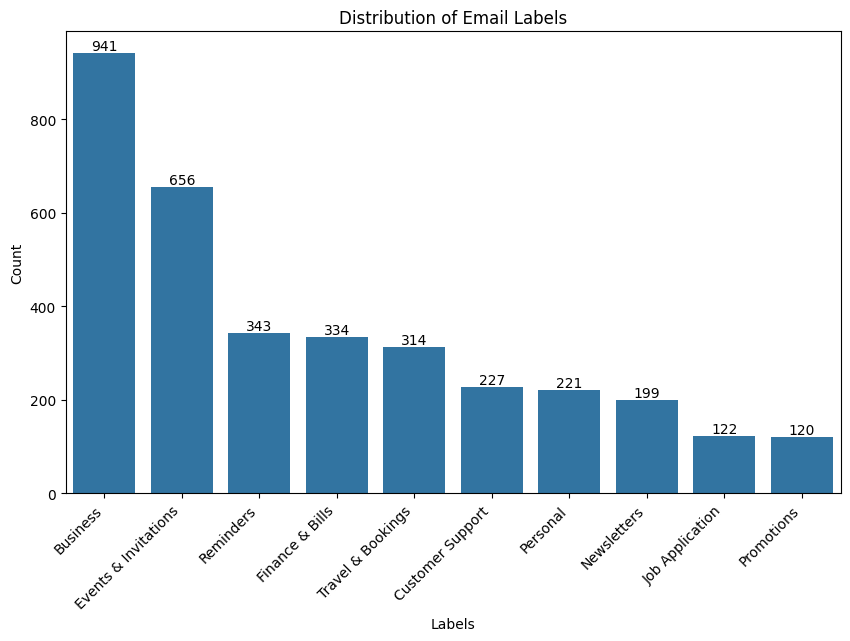

In [107]:
# Check the distribution of the target labels
all_labels = list(chain.from_iterable(dataset['train']['labels']))
label_counts = Counter(all_labels)

# Create simple visualization
plt.figure(figsize=(10, 6))
labels, counts = zip(*sorted(label_counts.items(), key=lambda x: x[1], reverse=True))
ax = sns.barplot(x=list(labels), y=list(counts))

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Email Labels')
plt.show()

#### **Data Preprocessing**

In [108]:
# Combine subject and body of each email into a single text field
def combine_text(examples):
    examples["text"] = examples["subject"] + " " + examples["body"]
    return examples


# Apply the function to the dataset
dataset = dataset.map(combine_text)

In [109]:
# Check the updated dataset
dataset["train"][0]

{'subject': 'Meeting Reminder: Quarterly Sales Review Tomorrow',
 'body': 'Dear Team, Just a friendly reminder that our Quarterly Sales Review meeting is scheduled for tomorrow at 10:00 AM in the conference room. Please make sure to bring your sales reports and any relevant updates. Coffee and pastries will be provided. Looking forward to a productive meeting. Best regards, [Your Name]',
 'labels': ['Business', 'Reminders'],
 'text': 'Meeting Reminder: Quarterly Sales Review Tomorrow Dear Team, Just a friendly reminder that our Quarterly Sales Review meeting is scheduled for tomorrow at 10:00 AM in the conference room. Please make sure to bring your sales reports and any relevant updates. Coffee and pastries will be provided. Looking forward to a productive meeting. Best regards, [Your Name]'}

In [110]:
# Split the dataset before further processing
split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

In [111]:
# Encode multi-labels using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(train_dataset["labels"])
num_labels = len(mlb.classes_)

In [112]:
# Tokenization
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Tokenize and encode from your original data
def tokenize_and_encode(examples):
    # Tokenize text
    tokenized = tokenizer(
        examples["text"], 
        truncation=True, 
        max_length=256,
        padding=False,
        return_tensors=None
    )
    
    # Encode labels
    encoded_labels = mlb.transform(examples["labels"])
    tokenized["labels_encoded"] = encoded_labels.astype(np.float32).tolist()
    
    return tokenized

# Apply to clean datasets 
train_dataset = train_dataset.map(tokenize_and_encode, batched=True)
test_dataset = test_dataset.map(tokenize_and_encode, batched=True)

# Remove unnecessary columns
train_dataset = train_dataset.remove_columns(["subject", "body", "text", "labels"])
test_dataset = test_dataset.remove_columns(["subject", "body", "text", "labels"])

print("Rebuilt datasets successfully!")
print("Train columns:", train_dataset.column_names)

Rebuilt datasets successfully!
Train columns: ['input_ids', 'attention_mask', 'labels_encoded']


In [113]:
# Verify the structure
print("Training sample:", train_dataset[0])

Training sample: {'input_ids': [101, 14764, 1024, 9046, 2136, 3116, 6203, 2136, 2372, 1010, 2023, 2003, 1037, 5379, 14764, 2008, 2057, 2031, 2256, 4882, 2136, 3116, 5115, 2005, 4826, 2012, 2184, 1024, 4002, 2572, 1012, 3531, 2191, 2469, 2000, 3319, 1996, 11376, 25828, 1998, 2272, 4810, 2007, 2151, 14409, 2030, 20062, 2000, 3745, 1012, 2292, 1005, 1055, 2031, 1037, 13318, 3116, 1998, 6848, 2256, 5082, 2006, 7552, 3934, 1012, 2559, 2830, 2000, 3773, 2017, 2035, 2045, 999, 2190, 12362, 1010, 1031, 2115, 2171, 1033, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels_encoded': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]}


In [114]:
# Prepare the label ids
id2label = {i: label for i, label in enumerate(mlb.classes_)}
label2id = {label: i for i, label in enumerate(mlb.classes_)}

# Check the mappings
print("ID to Label:", id2label)
print("Label to ID:", label2id)

ID to Label: {0: 'Business', 1: 'Customer Support', 2: 'Events & Invitations', 3: 'Finance & Bills', 4: 'Job Application', 5: 'Newsletters', 6: 'Personal', 7: 'Promotions', 8: 'Reminders', 9: 'Travel & Bookings'}
Label to ID: {'Business': 0, 'Customer Support': 1, 'Events & Invitations': 2, 'Finance & Bills': 3, 'Job Application': 4, 'Newsletters': 5, 'Personal': 6, 'Promotions': 7, 'Reminders': 8, 'Travel & Bookings': 9}


In [115]:
# Define the data collator for dynamic padding
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=True,           # Enable padding
    return_tensors="pt",    # Return PyTorch tensors
)

#### **Model Training**

In [116]:
# Setup and Configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Model configuration
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token if not present
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Model: {model_name}")
print(f"Device: {device}")

Using device: mps
Model: distilbert-base-uncased-finetuned-sst-2-english
Device: mps


In [117]:
# Create Train/Validation Split
print("Creating train/validation split...")

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_split, val_split = random_split(train_dataset, [train_size, val_size], generator=generator)

print(f"Training samples: {len(train_split)}")
print(f"Validation samples: {len(val_split)}")
print(f"Test samples: {len(test_dataset)}")

Creating train/validation split...
Training samples: 1347
Validation samples: 337
Test samples: 421


In [118]:
print("Setting up DistilBERT with LoRA...")

# Load base model for multi-label classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True
)

# LoRA configuration for efficient fine-tuning
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=16,                    # Rank
    lora_alpha=32,          # Scaling factor
    lora_dropout=0.1,       # Dropout for LoRA layers
    target_modules=["q_lin", "v_lin"],  # DistilBERT attention modules
)

# Apply LoRA
model = get_peft_model(model, lora_config)
model = model.to(device)

print("LoRA Model Information:")
model.print_trainable_parameters()

Setting up DistilBERT with LoRA...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA Model Information:
trainable params: 893,194 || all params: 67,854,356 || trainable%: 1.3163


In [119]:
# Calculate Class Weights for Imbalanced Data
def calculate_class_weights(dataset, mlb):
    """Calculate class weights to handle imbalanced data"""
    # Encode all training labels
    encoded_labels = mlb.transform(dataset['labels'])
    n_samples, n_classes = encoded_labels.shape
    
    class_weights = []
    print("\nClass Weight Calculation:")
    print("-" * 50)
    
    for i, label_name in enumerate(mlb.classes_):
        pos_count = np.sum(encoded_labels[:, i])
        neg_count = n_samples - pos_count
        
        # Calculate weight = negative_samples / positive_samples
        weight = neg_count / max(pos_count, 1)
        class_weights.append(weight)
        
        print(f"{label_name:15s}: {int(pos_count):4d} pos ({pos_count/n_samples*100:5.1f}%) → weight: {weight:.2f}")
    
    return torch.tensor(class_weights, dtype=torch.float32)

class_weights = calculate_class_weights(dataset['train'], mlb)
print(f"\nClass weights calculated")


Class Weight Calculation:
--------------------------------------------------
Business       :  941 pos ( 44.7%) → weight: 1.24
Customer Support:  227 pos ( 10.8%) → weight: 8.27
Events & Invitations:  656 pos ( 31.2%) → weight: 2.21
Finance & Bills:  334 pos ( 15.9%) → weight: 5.30
Job Application:  122 pos (  5.8%) → weight: 16.25
Newsletters    :  199 pos (  9.5%) → weight: 9.58
Personal       :  221 pos ( 10.5%) → weight: 8.52
Promotions     :  120 pos (  5.7%) → weight: 16.54
Reminders      :  343 pos ( 16.3%) → weight: 5.14
Travel & Bookings:  314 pos ( 14.9%) → weight: 5.70

Class weights calculated


In [1]:
# Enhanced visualization showing both counts and weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original count distribution (your existing code)
labels, counts = zip(*sorted(label_counts.items(), key=lambda x: x[1], reverse=True))
bars1 = ax1.bar(labels, counts, color='lightblue', edgecolor='navy', alpha=0.7)

for bar, count in zip(bars1, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{count}', ha='center', va='bottom', fontsize=9)

ax1.set_xlabel('Labels')
ax1.set_ylabel('Count')
ax1.set_title('Label Distribution (Counts)')
ax1.tick_params(axis='x', rotation=45)

# Class weights visualization
sorted_weights = [class_weights[mlb.classes_.tolist().index(label)].item() for label in labels]
bars2 = ax2.bar(labels, sorted_weights, color='lightcoral', edgecolor='darkred', alpha=0.7)

for bar, weight in zip(bars2, sorted_weights):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{weight:.1f}', ha='center', va='bottom', fontsize=9)

ax2.set_xlabel('Labels')
ax2.set_ylabel('Class Weight')
ax2.set_title('Class Weights (Higher = More Penalty for Mistakes)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Show the relationship
print("Imbalance Analysis:")
print("="*50)
for label, count, weight in zip(labels, counts, sorted_weights):
    percentage = (count / len(train_dataset)) * 100
    print(f"{label}: {count} samples ({percentage:.1f}%) → weight: {weight:.2f}")

NameError: name 'plt' is not defined